In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Calibration
## Estimation of parameters for constrained distributions

Apply a doubly constrained gravity model with composite cost from the network model (i.e. logsum of mode choice utility) as deterrence matrix. Zone production and attraction (trip generation) is determined elsewhere.

$T_{ij} = P_i * A_j * f(c_{ij})$

$f(c_{ij}) = ?$

Follow Poisson fitting to determine cost function parameters. Given $N$ observations $n_{ij}$ (number of trips per OD pair), the likelyhood becomes

$p(\{n_{ij}\}| P_i, A_j, f(c_{ij})) = \prod_{i,j \in N} \frac{exp(c*\lambda)*(c*\lambda)^{n_{ij}}}{n_{ij}!}$

$\lambda = T_{ij} = P_i * A_j * f(c_{ij})$

$c = \frac{\sum_{i,j \in N}n_{ij}}{T}$

With $P_i, A_j$ given, just divide observed OD matrix into distance bins and determine the value of $f(c_{ij})$ for each bin. Choose a suitable functional form and parameters for $f(c_{ij})$. This is basically a trip length distribution fitting.

Good introduction to methods can be found here: https://ocw.tudelft.nl/wp-content/uploads/2.2-Trip-distribution.pdf

In [3]:
input_path = '../input/'
model_path = '../model/' + scenario + '/'
output_path = '../output/'

## Load data

In [4]:
cols = ['mode_model', 'purpose_model', 'purpose2', 'car_avail', 'length', 'origin', 'destination', 'P_ID', 'W_GEW']
trips = pd.read_csv(input_path + 'transport_demand/calibration_all_trips_MiD2017.csv', usecols=cols)
len(trips)

254876

In [5]:
trips['segment'] = trips['purpose_model'] + trips['car_avail'].map({0: '_no_car', 1: '_car', 9: '_no_car'})

In [6]:
# Composite cost
cc = pd.read_csv(output_path + 'base' + '/mode_choice_od_composite_cost.csv')
cc.set_index(['origin', 'destination'], inplace=True)
cc.sort_index(inplace=True)
cc.clip(lower=0.01, inplace=True)

In [7]:
# merge
cc.columns.name = 'segment'
trips = trips.merge(cc.stack().rename('cc').to_frame(),
                    how='left', left_on=['origin', 'destination', 'segment'], right_index=True)

In [8]:
# inner-zonal cc
inner = pd.read_csv(input_path + 'inner-zonal_cc.csv', index_col=0)
inner.index.name = 'origin'
inner.columns.name = 'segment'
trips = trips.merge(inner.stack().rename('inner_cc').to_frame(),
                    how='left', left_on=['origin', 'segment'], right_index=True)

In [9]:
#bins = [-1, 5, 10, 15, 20, 30, 40, 50, 70, 100, 200, 500, 1000]
bins = [-1] + list(range(5, 100, 5)) + list(range(100, 300, 50)) + [300, 400, 500, 750, 1000]
trips['bin'] = pd.cut(trips['length'], bins=bins, labels=bins[1:])
trips = trips.loc[trips['bin'].notna()]
trips['bin'] = trips['bin'].astype(int)
len(trips)

254876

In [10]:
# Cleanse
trips = trips.loc[~((trips['inner_cc'].isna()) & (trips['origin']==trips['destination']))]
trips = trips.loc[~((trips['cc'].isna()) & (trips['origin']!=trips['destination']))]
trips['cc'] = trips['cc'].fillna(trips['inner_cc'])
trips = trips.loc[~((trips['bin']>20) & (trips['origin']==trips['destination']))]
len(trips)

251795

In [11]:
# Create CC+distance metric
trips['cc_dist'] = trips['cc'] + trips['length'] / 10

## Distance fitting

In [15]:
segments = sorted(list(set(trips['segment'])))
purposes = [s.split('_')[0] for s in segments][::2]

Text(0, 0.5, 'with car')

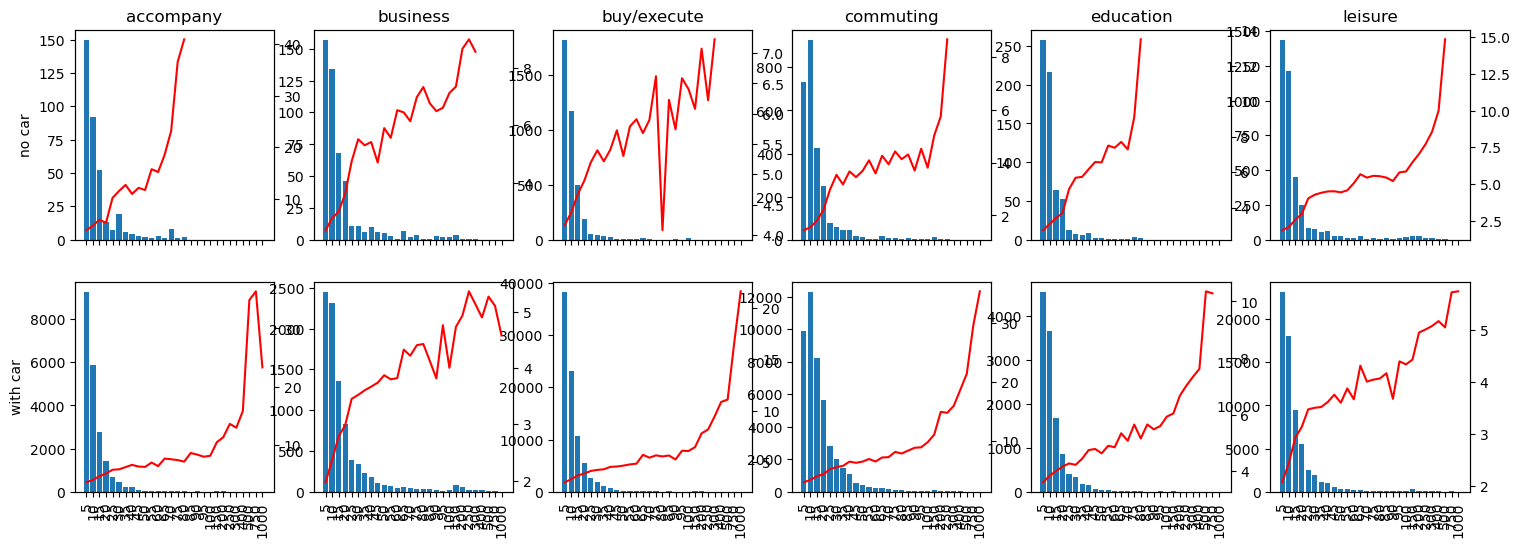

In [12]:
# Show number of trips and CC
fig, ax = plt.subplots(nrows=2, ncols=len(purposes), figsize=(18,6), sharex='all', sharey=False)
ind = np.arange(len(bins[1:]))
for i in [0,1]:
    for j in range(len(purposes)):
        mask = (trips['car_avail']==i) & (trips['purpose_model']==purposes[j])
        n_trips = trips.loc[mask, 'bin'].value_counts().sort_index()
        ax[i,j].bar(ind[:len(n_trips)], n_trips)
        ax[i,j].set_xticks(ind, bins[1:], rotation=90)
        ax2 = ax[i,j].twinx()
        ax2.plot(ind[:len(n_trips)], trips.loc[mask].groupby('bin')['cc'].mean(), color='red')
        ax2.set_xticks(ind, bins[1:], rotation=90)
        ax[0,j].set_title(purposes[j])
ax[0,0].set_ylabel('no car')
ax[1,0].set_ylabel('with car')

Text(0, 0.5, 'with car')

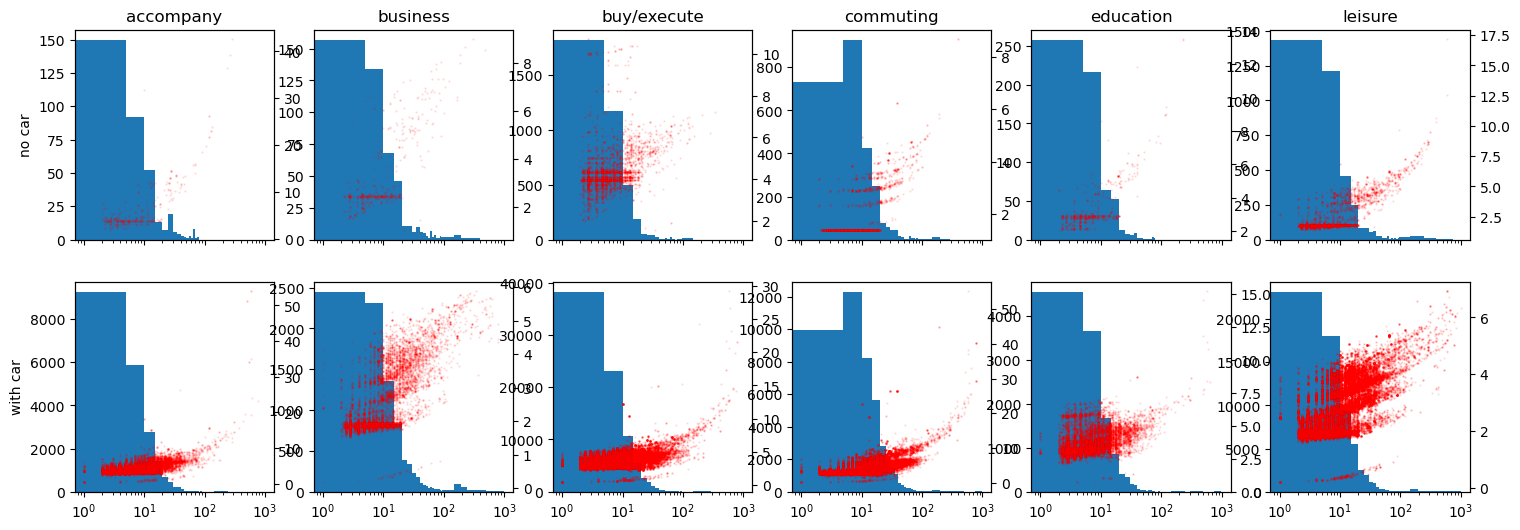

In [13]:
# Show number of trips and CC
fig, ax = plt.subplots(nrows=2, ncols=len(purposes), figsize=(18,6), sharex='all', sharey=False)
widths = [bins[dist]-bins[dist-1] for dist in range(2, len(bins))] + [0]
for i in [0,1]:
    for j in range(len(purposes)):
        mask = (trips['car_avail']==i) & (trips['purpose_model']==purposes[j])
        n_trips = trips.loc[mask, 'bin'].value_counts().sort_index()
        ax[i,j].bar([bins[1:][n] + widths[n]/2 -bins[1] for n in range(len(n_trips))], n_trips, width=widths[:len(n_trips)])
        ax[i,j].set_xscale('log')
        ax2 = ax[i,j].twinx()
        ax2.scatter(trips.loc[mask, 'length'], trips.loc[mask, 'cc'], s=.5, c='red', alpha=.1)
        ax2.set_xscale('log')
        ax[0,j].set_title(purposes[j])
ax[0,0].set_ylabel('no car')
ax[1,0].set_ylabel('with car')

In [12]:
# Define mathematical formulations for the cost term
def power_function(CC, a, b):
    return a * np.power(CC, -b)
def exponential_function(CC, a, b):
    return a * np.exp(-b * CC)
def lognormal_function(CC, a, b):
    return a * np.exp(-b * np.power(np.log(CC + 1), 2))
functions = [power_function, exponential_function, lognormal_function]

In [13]:
def get_r_square(observations, fitted_values):
    mean_observation = np.mean(observations)
    ss_total = np.sum((observations - mean_observation) ** 2)
    ss_residual = np.sum((observations - fitted_values) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared

In [16]:
# Estimate parameters
results = pd.DataFrame(columns=['segment', 'function', 'a', 'b', 'R2'])
for seg in segments:
    mask = trips['segment']==seg
    n_trips = trips.loc[mask, 'bin'].value_counts().sort_index()
    cc_means = trips.loc[mask].groupby('bin')['cc_dist'].mean()
    for f in functions:
        (a,b), _ = curve_fit(f, cc_means, n_trips)
        R2 = get_r_square(n_trips, f(cc_means, a,b))
        results.loc[len(results)] = [seg, f.__name__, a, b, R2]
results.set_index(['segment', 'function'], drop=True, inplace=True)

C:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)

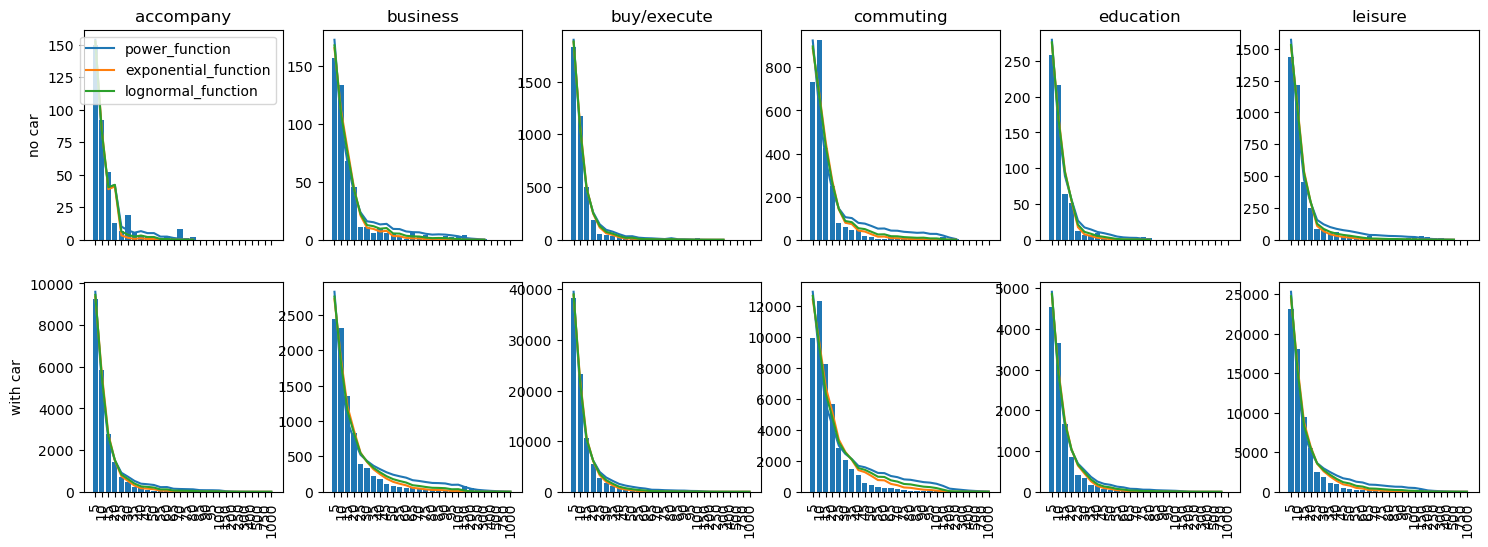

In [18]:
# Results for distance bins
fig, ax = plt.subplots(nrows=2, ncols=len(purposes), figsize=(18,6), sharex='all', sharey=False)
ind = np.arange(len(bins[1:]))
for i in [0,1]:
    for j in range(len(purposes)):
        mask = (trips['car_avail']==i) & (trips['purpose_model']==purposes[j])
        n_trips = trips.loc[mask, 'bin'].value_counts().sort_index()
        cc_means = trips.loc[mask].groupby('bin')['cc_dist'].mean()
        ax[i,j].bar(ind[:len(n_trips)], n_trips)
        for f in functions:
            seg = purposes[j]+{0:'_no_car',1:'_car'}[i]
            ax[i,j].plot(ind[:len(n_trips)],
                         f(cc_means, results.loc[(seg, f.__name__), 'a'], results.loc[(seg, f.__name__), 'b']),
                         label=f.__name__)
        ax[i,j].set_xticks(ind, bins[1:], rotation=90)
        ax[0,j].set_title(purposes[j])
ax[0,0].set_ylabel('no car')
ax[1,0].set_ylabel('with car')
ax[0,0].legend()

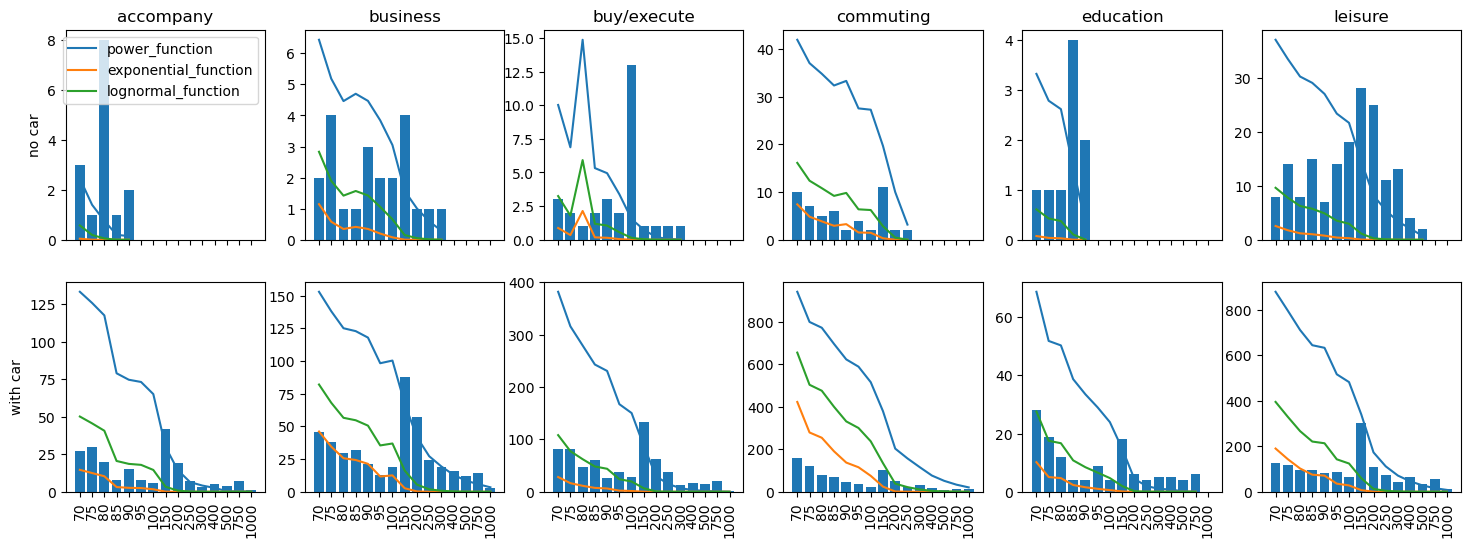

In [31]:
# Results for long-distance bins
fig, ax = plt.subplots(nrows=2, ncols=len(purposes), figsize=(18,6), sharex='all', sharey=False)
ind = np.arange(len(bins[int(len(bins)/2):]))
for i in [0,1]:
    for j in range(len(purposes)):
        mask = (trips['car_avail']==i) & (trips['purpose_model']==purposes[j])
        n_trips = trips.loc[mask, 'bin'].value_counts().sort_index()
        cc_means = trips.loc[mask].groupby('bin')['cc_dist'].mean()
        n_trips = n_trips.loc[bins[int(len(bins)/2)]:]
        cc_means = cc_means.loc[bins[int(len(bins)/2)]:]
        ax[i,j].bar(ind[:len(n_trips)], n_trips)
        for f in functions:
            seg = purposes[j]+{0:'_no_car',1:'_car'}[i]
            ax[i,j].plot(ind[:len(n_trips)],
                         f(cc_means, results.loc[(seg, f.__name__), 'a'], results.loc[(seg, f.__name__), 'b']),
                         label=f.__name__)
        ax[i,j].set_xticks(ind, bins[int(len(bins)/2):], rotation=90)
        ax[0,j].set_title(purposes[j])
ax[0,0].set_ylabel('no car')
ax[1,0].set_ylabel('with car')
ax[0,0].legend()

In [32]:
results

a         b        R2
segment            function                                              
accompany_car      power_function        8.250333e+05  3.281048  0.989529
                   exponential_function  1.041655e+05  0.620020  0.999284
                   lognormal_function    1.372371e+05  1.063150  0.997192
accompany_no_car   power_function        5.651658e+03  2.502520  0.943004
                   exponential_function  1.058952e+03  0.459029  0.941967
                   lognormal_function    1.298321e+03  0.783978  0.943793
business_car       power_function        1.389910e+04  1.877961  0.914587
                   exponential_function  8.138297e+03  0.468753  0.968856
                   lognormal_function    8.096696e+03  0.741838  0.957888
business_no_car    power_function        1.405282e+03  2.106894  0.952196
                   exponential_function  6.205549e+02  0.488369  0.978502
                   lognormal_function    6.443111e+02  0.783963  0.974454
buy/execute_car    power_function        3.216717e+06  3.608358  0.990712
                   exponential_function  6.128440e+05  0.815677  0.998911
                   lognormal_function    6.846137e+05  1.311363  0.997304
buy/execute_no_car power_function        3.813583e+06  5.050548  0.988622
                   exponential_function  1.251533e+05  0.932103  0.995608
                   lognormal_function    2.041855e+05  1.609790  0.993447
commuting_car      power_function        1.187769e+05  1.828707  0.866949
                   exponential_function  3.587041e+04  0.315309  0.936773
                   lognormal_function    4.360903e+04  0.570066  0.914673
commuting_no_car   power_function        2.560250e+03  1.730159  0.871973
                   exponential_function  2.319364e+03  0.533377  0.930971
                   lognormal_function    2.099048e+03  0.801005  0.923435
education_car      power_function        1.012911e+06  3.872420  0.964972
                   exponential_function  1.035269e+05  0.773882  0.979984
                   lognormal_function    1.355901e+05  1.297926  0.975587
education_no_car   power_function        6.096522e+03  2.744387  0.946054
                   exponential_function  2.105111e+03  0.662532  0.963244
                   lognormal_function    2.154312e+03  1.041268  0.959709
leisure_car        power_function        1.864576e+05  2.250649  0.952237
                   exponential_function  9.999410e+04  0.579515  0.987980
                   lognormal_function    9.756333e+04  0.903750  0.980986
leisure_no_car     power_function        8.963228e+03  2.195490  0.964939
                   exponential_function  6.255566e+03  0.640263  0.984724
                   lognormal_function    5.635296e+03  0.957840  0.982915

In [33]:
# Save results
results.to_csv(input_path + 'estimation_results_distribution.csv')